# Exploring UC1004 dataset

In [59]:
import sys
sys.path.insert(0, './utils/')

import geo_conv
import sqlite3 as sqlite
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix
from scipy.io import mmwrite, mmread
import folium

plt.style.use('ggplot')
%matplotlib inline

Database schema: network, us_pos, us_signal

In [2]:
def add_lat_lon(df):
    xy = zip(df.x.values, df.y.values)
    latlon = map(lambda (coord):geo_conv.convert_GK_to_lat_long(coord[0]+__XMIN, coord[1]+__YMIN), xy)
    
    if 'lat' not in df.columns:
        df = pd.concat([df, 
                        pd.DataFrame.from_records(latlon, columns=['lat', 'lon'])],
                       axis=1)
    else:
        df[['lat', 'lon']] = pd.DataFrame.from_records(latlon, columns=['lat', 'lon'])
        
    return df

In [3]:
__CITY_LAT = 52.3667
__CITY_LON = 9.7167
__XMIN = 4336000
__YMIN = 5794000

In [4]:
# Setting conntection to sqlite db
conn = sqlite.connect('./data/uc1004/uc1004.db')

## Getting Networkd data

In [5]:
# Get Network data file
query = 'SELECT * FROM network;'

network = pd.read_sql(query, conn)
network.shape

(195, 11)

In [6]:
network = add_lat_lon(network)
network.set_index('cell_id', inplace=True)
network.head(10)

,x,y,z,azimuth,tilt,transmit_pwr,type,eirp,bandwidth,centr_freq,lat,lon
cell_id,,,,,,,,,,,,
1,11980.62,9511.46,18,100,4,46,Kathrein 742212,63.5,10,1810,52.343905,9.767655
2,11976.05,9511.91,18,220,4,46,Kathrein 742212,63.5,10,1810,52.343908,9.767588
3,11974.14,9521.92,18,340,4,46,Kathrein 742212,63.5,10,1810,52.343998,9.767555
4,11327.24,14888.51,25,60,4,46,Kathrein 742212,63.5,10,1810,52.392010,9.755628
5,11327.24,14888.51,25,180,4,46,Kathrein 742212,63.5,10,1810,52.392010,9.755628
6,11327.24,14888.51,25,300,4,46,Kathrein 742212,63.5,10,1810,52.392010,9.755628
7,11874.95,12539.22,29,10,4,46,Kathrein 742212,63.5,10,1810,52.371065,9.764733
8,11876.16,12536.20,29,130,4,46,Kathrein 742212,63.5,10,1810,52.371039,9.764753
9,11872.84,12536.20,29,250,4,46,Kathrein 742212,63.5,10,1810,52.371038,9.764704


## Getting User Position

As it goes from the article, users are categorized to:<br\>
Vehicular: 0 ... 4619 <br\>
Pedestrian: 10000 ... 15246<br\>
Static Indoor: 20000 ... 29999

In [7]:
user_id = 10003
query = 'SELECT * FROM us_pos INDEXED BY user_index WHERE userid=%d' % user_id
user_pos = pd.read_sql(query, conn)

In [8]:
print user_pos.shape
user_pos.sort_values('time', inplace=True)
user_pos.head()

(14753, 5)


,time,userid,x,y,z
0,0.1,10003,9842.16,14497.20,1.5
1,0.2,10003,9842.03,14497.23,1.5
2,0.3,10003,9841.89,14497.27,1.5
3,0.4,10003,9841.75,14497.30,1.5
4,0.5,10003,9841.62,14497.33,1.5


In [9]:
# Adding lat, long columns
user_pos = add_lat_lon(user_pos)
user_pos.head()

,time,userid,x,y,z,lat,lon
0,0.1,10003,9842.16,14497.20,1.5,52.388080,9.734010
1,0.2,10003,9842.03,14497.23,1.5,52.388080,9.734008
2,0.3,10003,9841.89,14497.27,1.5,52.388080,9.734006
3,0.4,10003,9841.75,14497.30,1.5,52.388080,9.734004
4,0.5,10003,9841.62,14497.33,1.5,52.388081,9.734002


## Getting User's RSPS

In [10]:
query = 'SELECT * FROM us_signal INDEXED BY user_index_sig WHERE userid=%d' % user_id
user_signals = pd.read_sql(query, conn)

In [11]:
print user_signals.shape
user_signals.sort_values('time', inplace=True)
user_signals.head()

(14753, 42)


,time,userid,cell_id1,rsr1,cell_id2,rsr2,cell_id3,rsr3,cell_id4,rsr4,...,cell_id16,rsr16,cell_id17,rsr17,cell_id18,rsr18,cell_id19,rsr19,cell_id20,rsr20
0,0.1,10003,23,-64.70,138,-65.82,91,-65.90,187,-67.62,...,183,-79.48,21,-81.15,15,-81.61,136,-81.87,140,-81.88
1,0.2,10003,23,-64.71,138,-65.82,91,-65.91,187,-67.73,...,183,-79.48,21,-81.21,15,-81.65,140,-81.85,136,-81.87
2,0.3,10003,23,-64.72,91,-65.87,138,-65.88,187,-67.78,...,183,-79.48,21,-81.23,15,-81.66,140,-81.86,136,-81.92
3,0.4,10003,23,-64.72,91,-65.87,138,-65.87,187,-67.83,...,183,-79.49,21,-81.26,15,-81.69,140,-81.84,136,-81.92
4,0.5,10003,23,-64.72,91,-65.87,138,-65.87,187,-67.93,...,183,-79.49,21,-81.31,15,-81.73,140,-81.82,136,-81.92


In [12]:
# Identify cell set for user
cell_id_cols = range(2, 42, 2)
cell_ids = np.unique(user_signals.iloc[:, cell_id_cols].values.astype(int))

## Plotting Maps From Dataset

### Land-case map

In [13]:
# Land-case map
use_map = np.genfromtxt('./data/uc1004/Land_Use_Map.csv', delimiter=';')

In [14]:
print use_map.shape # It differes from info in the article
print np.unique(use_map)

(601, 1201)
[  2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.]


In [15]:
# .T to have refference with pics in the article
# But map shoulb be rotated by 90 degrees (according to google maps)
# Moreover, the map in data is not the same as in the article..
# fig = plt.figure(figsize=(10, 20))
# plt.imshow(use_map.T, cmap='flag')

In [16]:
use_map = np.rot90(use_map)

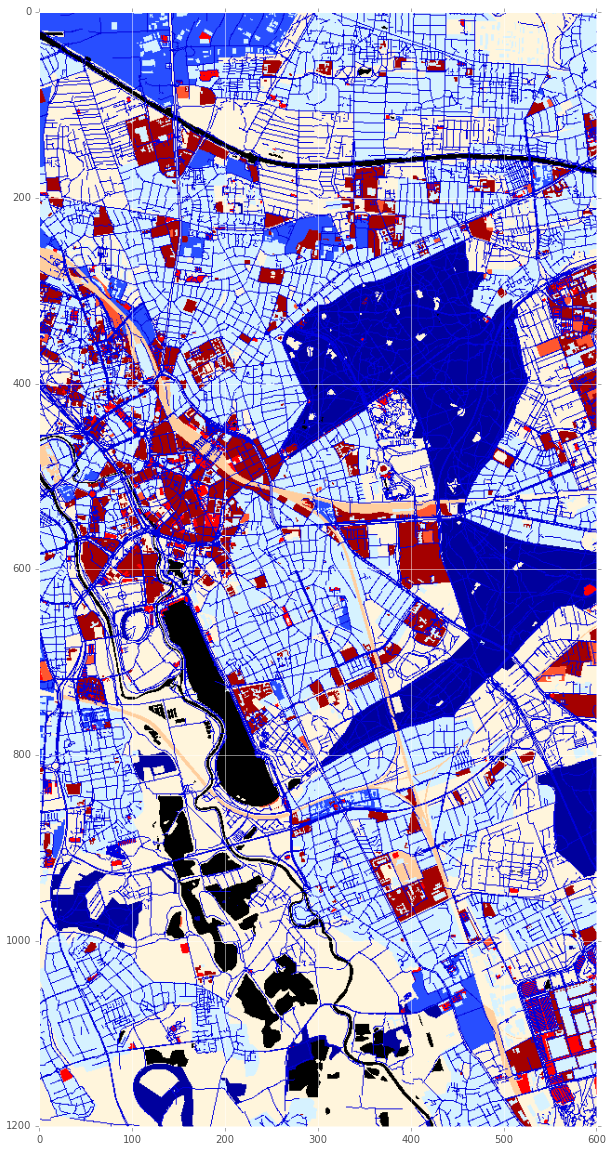

In [17]:
fig = plt.figure(figsize=(10, 20))
plt.imshow(use_map, cmap='flag')

### Best server map

In [18]:
best_server = np.genfromtxt('./data/uc1004/Best_Server_Map.csv', delimiter=';')

In [19]:
print best_server.shape # It differes from info in the article
print np.unique(best_server) # should be at least = to # of cells

(601, 1201)
[   0.    1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.
   12.   13.   14.   15.   16.   17.   18.   19.   20.   21.   22.   23.
   24.   25.   26.   27.   28.   29.   30.   31.   32.   33.   34.   35.
   36.   37.   38.   39.   40.   41.   43.   46.   48.   49.   50.   54.
   57.   58.   59.   64.   65.   72.   73.   74.   84.   85.   86.   87.
   88.   89.   90.   91.   92.   99.  100.  101.  106.  111.  112.  113.
  129.  130.  131.  132.  133.  134.  135.  136.  137.  138.  139.  140.
  141.  142.  143.  144.  147.  148.  150.  151.  152.  159.  160.  161.
  162.  163.  164.  168.  169.  172.  173.  174.  175.  176.  177.  178.
  179.  180.  181.  182.  183.  184.  185.  186.  187.]


In [20]:
best_server = np.rot90(best_server)

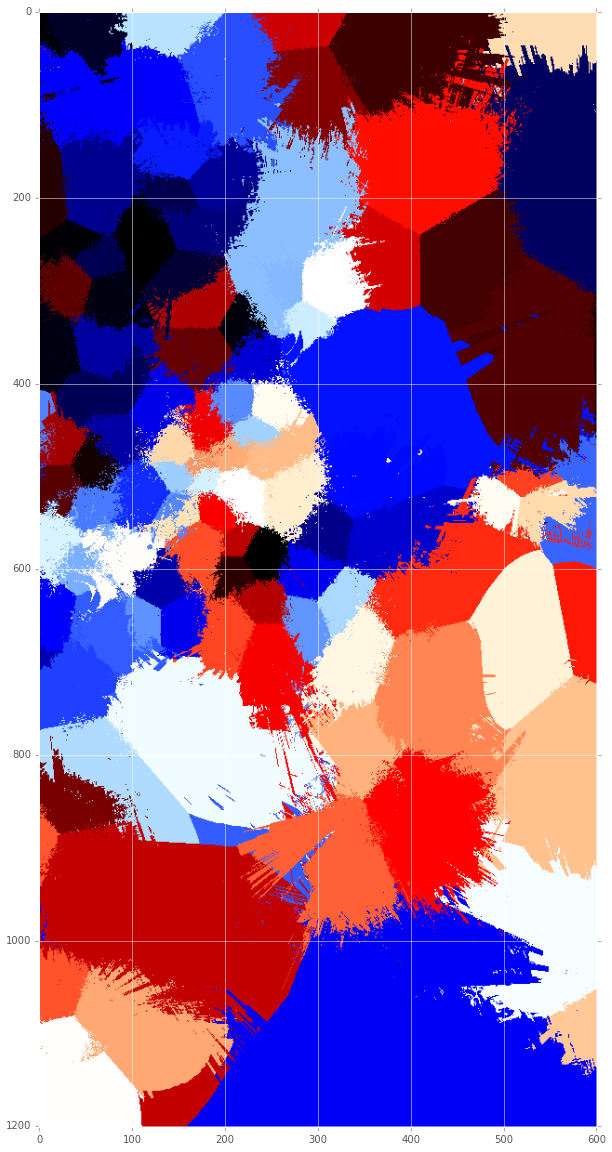

In [21]:
fig = plt.figure(figsize=(10, 20))
plt.imshow(best_server, cmap='flag')

## Generating map with user route and cell positions

In [22]:
map_hannover = folium.Map(location=[__CITY_LAT, __CITY_LON], 
                          zoom_start=15)
map_hannover.line(locations=user_pos[['lat', 'lon']].values,
                  line_opacity=0.5, 
                  popup=('user: ' + str(user_id)))
for cid in cell_ids:
    cell = network.loc[cid]
    map_hannover.polygon_marker(location=[cell.lat, cell.lon],
                                num_sides=3,
                                radius=5,
                                rotation=cell.azimuth,
                                popup='cell_id: ' + str(cid) + '\nazimuth: ' + str(cell.azimuth))

map_hannover.create_map(path='./data/uc1004/map.html')

## Looking at RSS

In [23]:
signals_long = (pd.wide_to_long(user_signals, ['cell_id', 'rsr'], i='time', j='cell_order')
                  .reset_index()
                  .set_index(['cell_id', 'time'])
                  .sort_index(level=0))
signals_long.head()

cell_order  userid    rsr
cell_id time                           
6       0.6           20   10003 -81.92
        0.7           20   10003 -81.92
        0.8           20   10003 -81.92
        0.9           20   10003 -81.92
        1.0           20   10003 -81.92

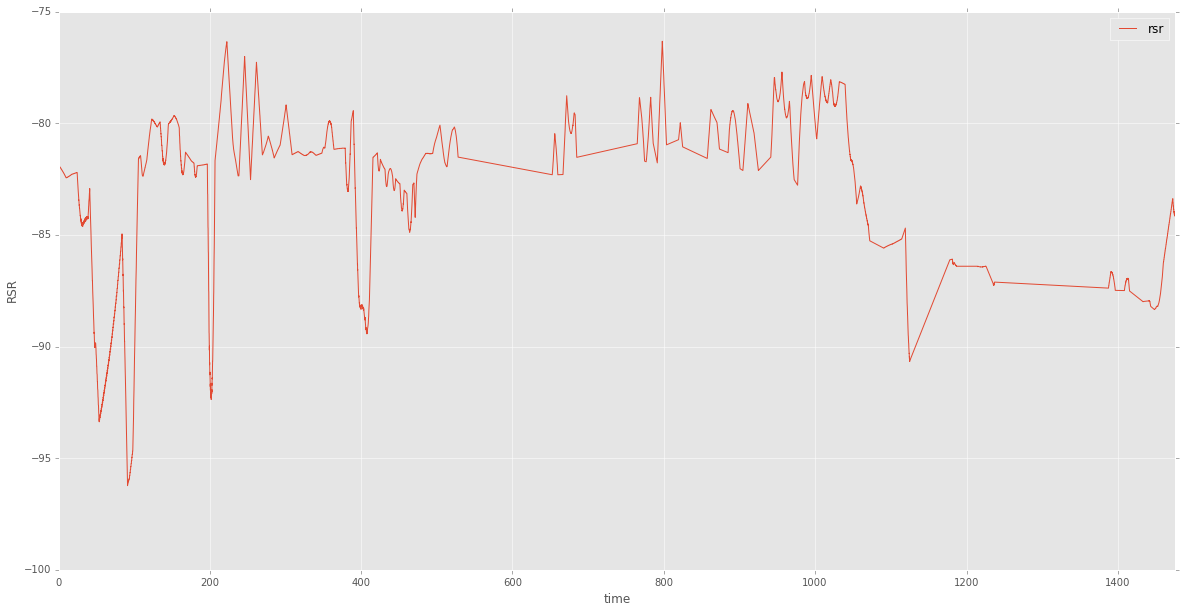

In [24]:
cell_id = 6
signals_long.loc[cell_id].plot(y='rsr'
                              )
fig = plt.gcf()
fig.set_size_inches(20,10)
plt.ylabel('RSR')
plt.xlabel('time')

## Plotting Distance vs RSR

In [25]:
# Picking cell and its RSR
cell_id = 152
cell_ss = signals_long.loc[cell_id].reset_index(drop=False)

# Considering only cases when it is in top-2 of RSR rating
cell_ss = cell_ss[cell_ss.cell_order <= 2]

# Cell info
cell_info = network.loc[cell_id]
user_dist = np.sqrt((user_pos.x - cell_info.x)**2 + (user_pos.y - cell_info.y)**2)

# Considering relevant timestamps
idx = user_pos.time.isin(cell_ss.time)
user_dist = user_dist.ix[idx]

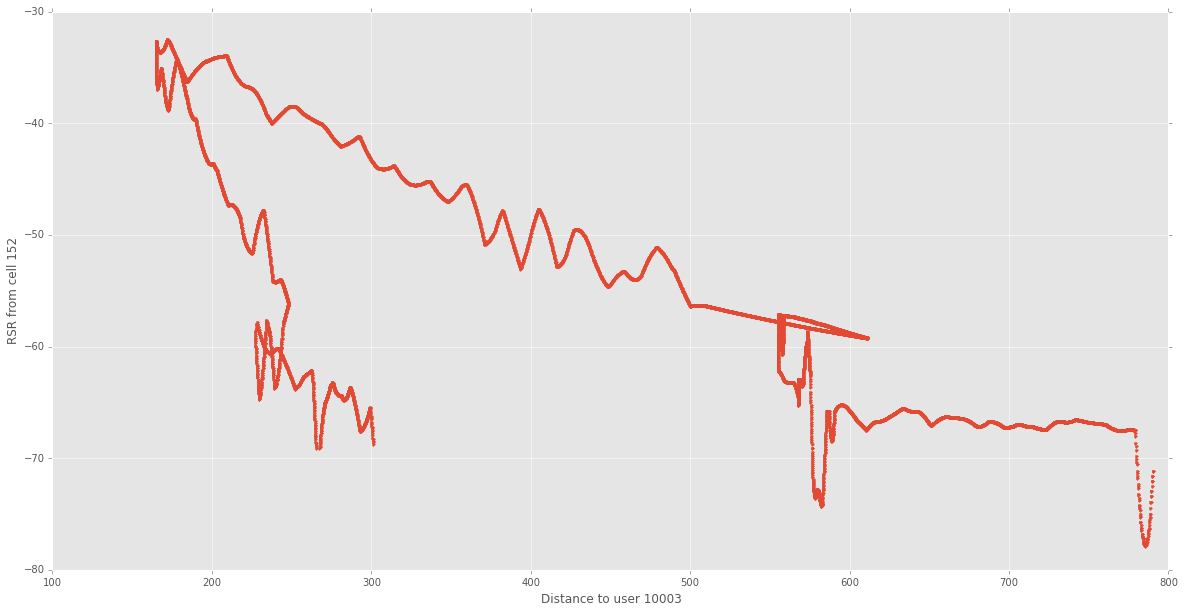

In [26]:
# Plotting

fig = plt.figure(figsize=(20,10))
plt.plot(user_dist, cell_ss.rsr, '.')
plt.xlabel('Distance to user %d' % user_id)
plt.ylabel('RSR from cell %d' % cell_id)

# k-NN baseline

### Train\test first look

Picking first 1000 users' positions and their rsr <br/>
First 500 going to training set. Others - to test <br/>
Distance measure - cosine distance

In [5]:
# # So slow..
# query = '''SELECT * FROM us_pos INDEXED BY user_index 
#            WHERE userid >= 0 AND userid <= 999;'''

# chunker = pd.read_sql(query, conn, chunksize=10**5)
# df_user_pos = pd.DataFrame()
# for chunk in chunker:
#     df_user_pos = df_user_pos.append(chunk)


# Export to csv is still slow, but import is rather fast..
col_types = {'time': np.dtype(float),
             'userid': np.dtype(int),
             'x': np.dtype(float),
             'y': np.dtype(float)}

df_user_pos = pd.read_csv('./data/uc1004/us_pos_exper.csv', 
                          header=0,
                          dtype=col_types,
                          usecols=col_types.keys())

In [6]:
# I have a strong feeling, that my computer's memory will be overfilled...
df_user_pos.shape

(5435392, 4)

In [7]:
# # So Slow..
# query = '''SELECT * FROM us_signal INDEXED BY user_index_sig 
#            WHERE userid >= 0 AND userid <= 999;'''

# chunker = pd.read_sql(query, conn, chunksize=10**5)
# for chunk in chunker:
#     df_user_rsr = df_user_rsr.append(chunk)
# df_user_rsr.shape

# # Manual transform to long format:
# fout = open('./data/uc1004/us_sig_long.csv', 'w')
# with open('./data/uc1004/us_sig_exper.csv', 'r') as fin:
#     fin.readline() # skip header line
#     fout.write('time,userid,cellid,cell_order,rsr\n')
#     for line in fin:
#         line = line.split(',')
#         time = line[0]
#         userid = line[1]
#         for order in xrange(1,21):
#             cellid = line[2+2*(order-1)]
#             rsr = line[1+2*(order)]
#             fout.write('%s,%s,%s,%s,%s\n' % (time, userid, cellid, order, rsr))
# fout.close()

# # Overflow...
# # Exportin long format
# col_types = {'time': np.dtype(float),
#              'userid': np.dtype(int),
#              'cellid': np.dtype(int),
#              'order': np.dtype(int),
#              'rsr': np.dtype(float)}
    
# df_user_rsr = pd.read_csv('./data/uc1004/us_sig_long.csv', 
#                           header=0,
#                           dtype=col_types)

# The only reasonably fast method and 
# memory-save method
col_types = {'time': np.dtype(float),
             'userid': np.dtype(int)}
for i in xrange(1, 21):
    col_types['cell_id%d' % i] = np.dtype(int)
    col_types['rsr%d' % i] = np.dtype(float)
    
df_user_rsr = pd.read_csv('./data/uc1004/us_sig_exper.csv', 
                          header=0,
                          dtype=col_types)

In [8]:
df_user_rsr.set_index(['userid', 'time'], inplace=True)
df_user_rsr.shape

(5435392, 40)

In [9]:
# Lets look at the roots in train\test
df_user_pos.set_index('userid',  inplace=True)

In [61]:
map_hannover = folium.Map(location=[__CITY_LAT, __CITY_LON], 
                          zoom_start=15)

for index, user_data in df_user_pos.groupby(level=0):
    user_data = add_lat_lon(user_data.reset_index())
    user_data.sort_values('time', inplace=True)
    if index < 500:
        map_hannover.line(locations=user_data[['lat', 'lon']].values,
                          line_opacity=0.2,
                          line_color='blue')
    else: 
        map_hannover.line(locations=user_data[['lat', 'lon']].values,
                          line_opacity=0.2,
                          line_color='red')

# Careful, ~200mb
map_hannover.create_map(path='./data/uc1004/test_train_map.html')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

There is an opinion, that it is better to make random train\test split. According to the map some areas more filled with train, rather than test.

### Building obj-feat matrix

So, for each position we have to build a feature vector, which is an average signal strength for this position from all the cells

In [10]:
df_user_pos.reset_index(inplace=True, drop=False)

# remove floatting point
df_user_pos.x = df_user_pos.x.astype(int)
df_user_pos.y = df_user_pos.y.astype(int)

df_user_pos.set_index(['x','y'], inplace=True)
df_user_pos.sort_index(inplace=True)
idx_train = df_user_pos.userid < 500

# Helpful stuff
rename_dict = {}
for i in xrange(1,21):
    rename_dict['cell_id%d'%i] = 'cell_id'
    rename_dict['rsr%d'%i] = 'rsr'

In [61]:
# Something to init
train_pos_num = len(df_user_pos[idx_train].index.unique())
test_pos_num = len(df_user_pos[~idx_train].index.unique())
pos_train = np.empty((train_pos_num,2))
pos_test = np.empty((test_pos_num,2))

cell_num = 195 # actually there are less in the data..

X_train = dok_matrix((train_pos_num, cell_num))
X_test = dok_matrix((train_pos_num, cell_num))

In [ ]:
# Filling train matrix
# ToDo: rename variables
ind = 0
for pos, pos_data in df_user_pos[idx_train].groupby(level=[0,1]):
    pos_train[ind, :] = pos
    
    idx = zip(pos_data.userid.values, np.round(pos_data.time.values, 1))
    sig_data = df_user_rsr.loc[idx].dropna()
    
    if sig_data.shape[0]:
        avg = (pd.concat([sig_data[['cell_id%d'%i,'rsr%d'%i]].rename(columns=rename_dict) for i in xrange(1,21)],
                         axis=0, ignore_index=True)
                 .groupby('cell_id')
                 .rsr.agg(np.nanmean))
        X_train[ind, avg.index.values] = avg.values
    
    ind+=1
    if np.mod(ind, 10000)==0:
        print ind
        
mmwrite('X_train', X_train)
mmwrite('pos_train', pos_test)

In [ ]:
# Filling test matrix
ind = 0
for pos, pos_data in df_user_pos[~idx_train].groupby(level=[0,1]):
    pos_test[ind, :] = pos
    
    idx = zip(pos_data.userid.values, np.around(pos_data.time.values, 1))
    sig_data = df_user_rsr.loc[idx].dropna()
    
    if sig_data.shape[0]:
        avg = (pd.concat([sig_data[['cell_id%d'%i,'rsr%d'%i]].rename(columns=rename_dict) for i in xrange(1,21)],
                         axis=0, ignore_index=True)
                 .groupby('cell_id')
                 .rsr.agg(np.nanmean))
        X_test[ind, avg.index.values] = avg.values       
       
    ind+=1
    if np.mod(ind, 10000)==0:
        print ind  
        
mmwrite('X_test', X_test)
mmwrite('pos_test', pos_test)